In [1]:
import datetime
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib.plugins.sparql.parser import parseQuery
import csv
import urllib
import itertools
import json
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import colors
import numpy
import matplotlib.pyplot as plt


In [140]:

with open("results_old.json") as f:
    data = json.load(f)

failed = data["failed"]

exclude = []
exclude.append("http://www.bigdata.com/")
exclude.append("http://www.bigdata.com/")

print("read tsv file...")

# total number of queries
sample_r = []
count = 0
with open("I7_status2xx_Joined.tsv") as file:
    tsv_file = csv.reader(file, delimiter="\t")
    for line in tsv_file:
        count = count + 1
        if count > 1:
            query = (
                urllib.parse.unquote_plus(line[0])
                .replace("> *", ">*")
                .replace("> / <", ">/<")
                .replace("> | <", ">|<")
            )
            sample_r.append(query)
            # if 'http://www.bigdata.com/' not in query and 'wikibase:label' not in query:
            if count == 200001:
                break
print(len(sample_r))


def filter(x):
    return "http://www.bigdata.com" in x or "MINUS" in x


sample_no_minus = itertools.filterfalse(filter, sample_r)
sample = [x for x in sample_no_minus]
print(len(sample))


read tsv file...
200000
176927


In [81]:
print(len(sample), len(failed))

failed_queries = [sample[i] for i in range((len(failed))) if failed[i]]
valid_queries = [sample[i] for i in range((len(failed))) if not failed[i]]

print(len(failed_queries), len(valid_queries))

with open("query_dump_10k_failed.json", "w") as f:
    json.dump(failed_queries, f, indent=2)
with open("query_dump_10k_valid.json", "w") as f:
    json.dump(valid_queries, f, indent=2)


176927 23110
13110 10000


In [160]:
def filter(x: str):
    return (">*" in x or ">+" in x or ">|<" in x or " | " in x or ">? " in x or ">/<" in x or "^(" in x) and ("REGEX" not in x)

rec_queries = set(i for (i, e) in enumerate(valid_queries) if filter(e))

len(rec_queries)

916

QLever (rec) max: 40.388502 min: -60.0 mean: -0.19967355515191546 median: 0.13185050000000004 10000 9539 95.39 size: 95
Virtuoso (rec) max: 60.0 min: -60.0 mean: 0.0688316759136944 median: 0.15351900000000002 10000 9584 95.84 size: 95
Blazegraph (rec) max: 46.985898999999996 min: -60.0 mean: 0.013307189343901363 median: 0.17587199999999997 10000 9609 96.09 size: 95


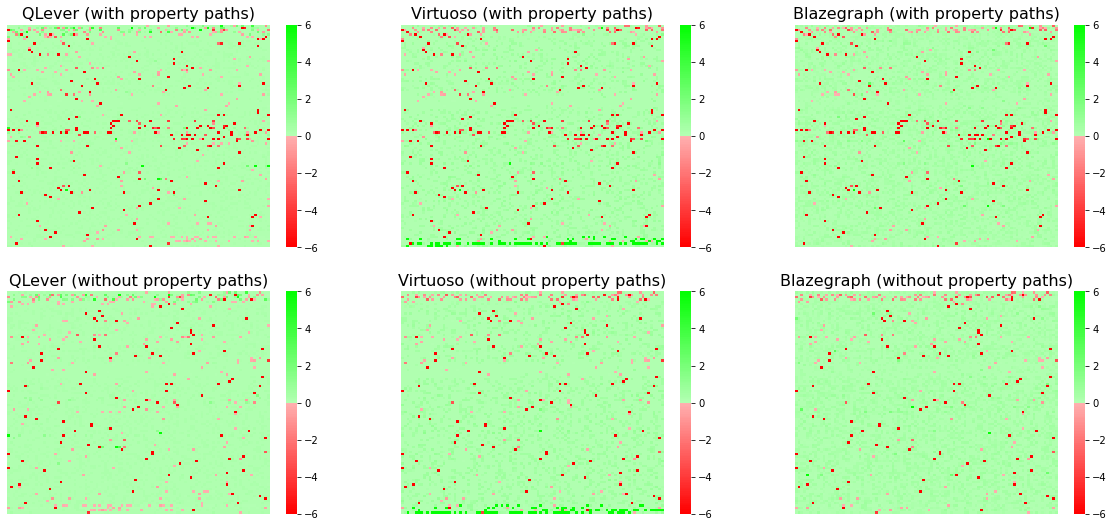

In [172]:
from math import sqrt

CLAMP_SECONDS=6
QEP_ID = "qe"  # qe

with open("results_old.json") as f:
    data = json.load(f)


with open("query_dump_10k_valid.json") as f:
    queries = json.load(f)

qendpoint_engine = None
for engine in data["engines"]:
    eid = engine["id"]
    ename = engine["name"]
    etime = engine["time1"]
    if eid == QEP_ID:
        qendpoint_engine = engine
        qendpoint_name = ename
        break

if qendpoint_engine is None:
    print("qendpoint_engine is none!!!")
else:
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 9))
    fig.set_facecolor("white")
    axis_i = 0
    for engine in data["engines"]:
        eid = engine["id"]
        title = engine["name"]
        time1 = engine["time1"]
        time2 = qendpoint_engine["time1"]

        if len(time2) != len(time1):
            print("time1!=time2 for engine", title)
            break

        if eid == QEP_ID:
            continue


        deltas = numpy.array(
            [(time1[i] - time2[i]) / 1000 for i in range(0, len(time1))])
        diff_time = numpy.array(
            [max(min(d, CLAMP_SECONDS), -CLAMP_SECONDS) for d in deltas])

        deltas2 = numpy.array(
            [max(min(e, 60), -60) for (i, e) in enumerate(deltas) if i not in rec_queries])
        diff_time2 = numpy.array(
            [max(min(d, CLAMP_SECONDS), -CLAMP_SECONDS) for d in deltas2])

        sq_size = int(sqrt(len(diff_time)))
        sq_size2 = int(sqrt(len(diff_time2)))

        print(
            title, 
            "(rec)",
            "max:",
            numpy.max(deltas2),
            "min:",
            numpy.min(deltas2),
            "mean:",
            numpy.mean(deltas2),
            "median:",
            numpy.median(deltas2),
            len(deltas),
            len([i for i in deltas if i >= 0]),
            len([i for i in deltas if i >= 0]) / 10000 * 100,
            "size:", 
            sq_size2
        )

        # fig = plt.figure(figsize=(12, 9))

        def get_custom_color_palette():
            return ListedColormap(
                [
                    *[(1, 0, 0, alpha) for alpha in numpy.arange(1, 0.3, -0.01)],
                    *[(0, 1, 0, alpha) for alpha in numpy.arange(0.3, 1, 0.01)],
                ]
            )

        arr = numpy.reshape(
            diff_time[: sq_size * sq_size], (sq_size, sq_size), order="C")
        arr2 = numpy.reshape(
            diff_time2[: sq_size2 * sq_size2], (sq_size2, sq_size2), order="C")
        # print(arr)
        # fig, axis = plt.subplots(figsize = (12, 9))
        ax = axs[0, axis_i]
        ax2 = axs[1, axis_i]
        axis_i += 1
        sns.heatmap(arr, cmap=get_custom_color_palette(), center=0, vmax=CLAMP_SECONDS, vmin=-CLAMP_SECONDS, ax=ax)
        ax.set_title(title + " (with property paths)", fontsize=16)
        ax.set_axis_off()

        sns.heatmap(arr2, cmap=get_custom_color_palette(
        ), center=0, vmax=CLAMP_SECONDS, vmin=-CLAMP_SECONDS, ax=ax2)
        ax2.set_title(title + " (without property paths)", fontsize=16)
        ax2.set_axis_off()
    plt.savefig("values2.png", bbox_inches='tight')


In [86]:

timeqep = [e for e in enumerate(qendpoint_engine["time1"][:300])]
timeqep.sort(key=lambda e: -e[1])

sorted_queries = [(valid_queries[i], time, i) for (i, time) in timeqep]

with open("query_dump_10k_valid_sorted_qep.json", "w") as f:
    json.dump(sorted_queries, f, indent=2)
